In [2]:
########################
import pandas as pd  
import numpy as np
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import rcParams
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
##############################################
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

df = pd.read_csv('D:/Credit Card Fraud Detection/creditcard.csv')
df.isnull().values.any()
Fdf = df[df.Class == 1 ]
Ndf = df[df.Class == 0 ]
transactions = df.drop(['Time'],axis = 1)
transactions.Amount = StandardScaler().fit_transform(transactions.Amount.values.reshape(-1,1))
X_train, X_test = train_test_split(transactions, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
##################################

epoch [1/100], loss:0.8428
epoch [2/100], loss:0.7721
epoch [3/100], loss:0.7370
epoch [4/100], loss:0.7269
epoch [5/100], loss:0.7235
epoch [6/100], loss:0.7211
epoch [7/100], loss:0.7194
epoch [8/100], loss:0.7180
epoch [9/100], loss:0.7160
epoch [10/100], loss:0.7152
epoch [11/100], loss:0.7149
epoch [12/100], loss:0.7144
epoch [13/100], loss:0.7138
epoch [14/100], loss:0.7136
epoch [15/100], loss:0.7136
epoch [16/100], loss:0.7130
epoch [17/100], loss:0.7127
epoch [18/100], loss:0.7124
epoch [19/100], loss:0.7123
epoch [20/100], loss:0.7122
epoch [21/100], loss:0.7118
epoch [22/100], loss:0.7115
epoch [23/100], loss:0.7116
epoch [24/100], loss:0.7114
epoch [25/100], loss:0.7112
epoch [26/100], loss:0.7111
epoch [27/100], loss:0.7110
epoch [28/100], loss:0.7107
epoch [29/100], loss:0.7103
epoch [30/100], loss:0.7103
epoch [31/100], loss:0.7102
epoch [32/100], loss:0.7101
epoch [33/100], loss:0.7098
epoch [34/100], loss:0.7101
epoch [35/100], loss:0.7100
epoch [36/100], loss:0.7099
e

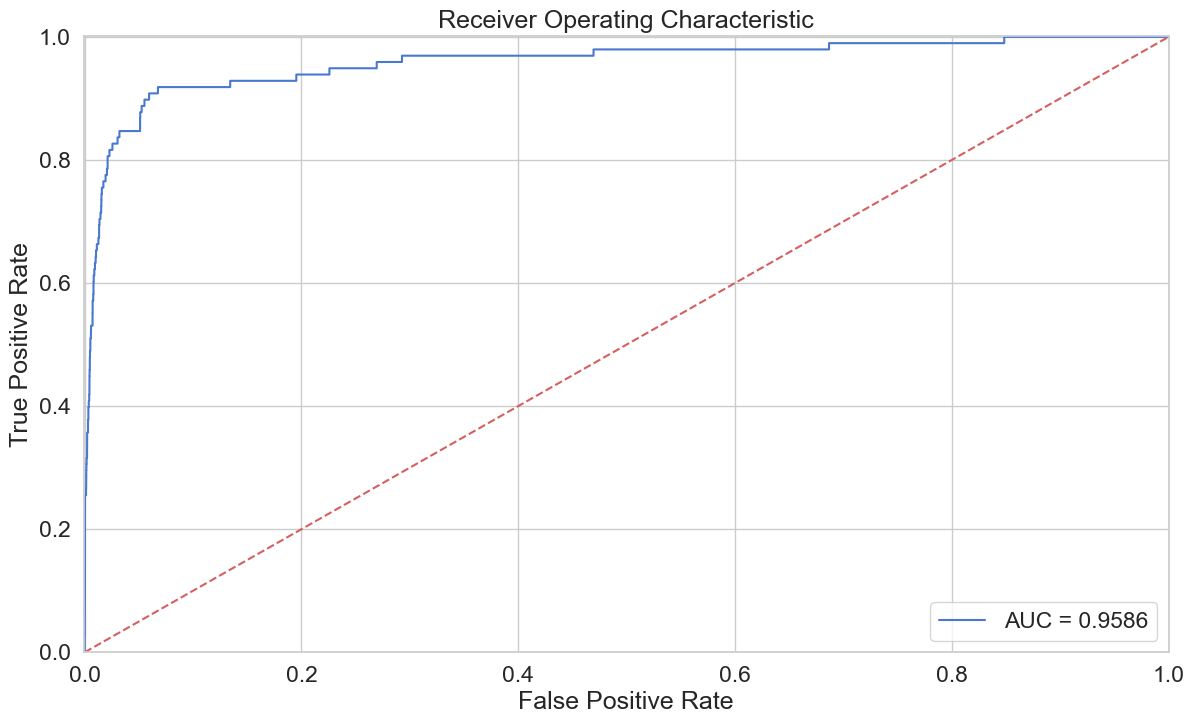

Card Precision at k=100: 0.26


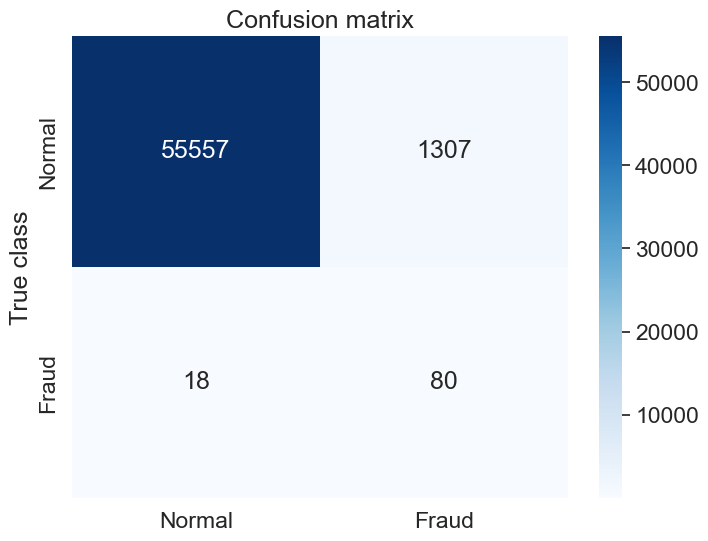

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            nn.Tanh(),
            nn.Linear(14,7),
            nn.ReLU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            nn.Tanh(),
            nn.Linear(7, 29),
            nn.ReLU()
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

model = Autoencoder().double().cpu()
num_epochs = 100
minibach_size = 32
lr = 1e-3
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=lr, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
 

pred_losses = { 'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]

conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap='Blues')  # Use 'Blues' directly
plt.title("Confusion matrix")
plt.ylabel('True class')
from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

# Calculate card precision at k
pred_scores = reconstructionErrorDF['pred_loss'].values
k = 100
card_precision = card_precision_at_k(pred_scores, y_test, k=k)
print(f"Card Precision at k={k}: {card_precision}")

In [6]:
import optuna
import pandas as pd  
import numpy as np
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import rcParams
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
##############################################
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

df = pd.read_csv('D:/Credit Card Fraud Detection/creditcard.csv')
df.isnull().values.any()
Fdf = df[df.Class == 1 ]
Ndf = df[df.Class == 0 ]
transactions = df.drop(['Time'],axis = 1)
transactions.Amount = StandardScaler().fit_transform(transactions.Amount.values.reshape(-1,1))
X_train, X_test = train_test_split(transactions, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

class GELU(nn.Module):
    def __init__(self, sigma):
        super(GELU, self).__init__()
        self.sigma = sigma

    def forward(self, input):
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp

class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class Autoencoder(nn.Module):
    def __init__(self, trial):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            GEU(sigma=trial.suggest_float('sigma_1', 0.01, 5.0)),
            nn.Linear(14,7),
            GELU(sigma=trial.suggest_float('sigma_2', 0.01, 5.0))
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            GEU(sigma=trial.suggest_float('sigma_3', 0.01, 5.0)),
            nn.Linear(7, 29),
            GELU(sigma=trial.suggest_float('sigma_4', 0.01, 5.0))
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

num_epochs = 100
minibach_size = 32
lr = 1e-3

from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
    
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()


best_target = float('-inf')  # 初始设为一个很大的值

def objective(trial):
    global best_target
    model = Autoencoder(trial).double().cpu()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10e-05)
    history = {}
    history['train_loss'] = []
    history['test_loss'] = []
    for epoch in range(num_epochs):
        h = np.array([])
        for data in train_loader:
            # ===================forward=====================
            output = model(data)
            loss = criterion(output, data)
            h = np.append(h, loss.item())
        
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # ===================log========================
        mean_loss = np.mean(h)
        if (epoch + 1) % 10 == 0:
            print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, mean_loss))
        history['train_loss'].append(mean_loss)
    pred_losses = { 'pred_loss' : []}
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs = data
            outputs = model(inputs)
            loss = criterion(outputs, inputs).data.item()
            pred_losses['pred_loss'].append(loss)
    reconstructionErrorDF = pd.DataFrame(pred_losses)
    reconstructionErrorDF['Class'] = y_test
    fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
    roc_auc = auc(fpr, tpr)
    reconstructionErrorDF = pd.DataFrame(pred_losses)
    reconstructionErrorDF['Class'] = y_test
    print(roc_auc)
    # Calculate card precision at k
    pred_scores = reconstructionErrorDF['pred_loss'].values
    card_precision = card_precision_at_k(pred_scores, y_test, k=100)
    print(f"Card Precision at k=100: {card_precision}")
    
    target_value = roc_auc + card_precision

    if target_value > best_target:
        best_target = target_value
        threshold = np.percentile(reconstructionErrorDF['pred_loss'], 90)  
        y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
        conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
        print(conf_matrix)
    
    # The objective is the sum of ROC AUC and Card Precision
    return target_value
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Number of trials

# Print the best trial
print(f"Best trial: {study.best_trial}")

[I 2024-12-23 20:30:26,393] A new study created in memory with name: no-name-d9751b4b-f071-43c0-815a-760af583596e


epoch [10/100], loss:0.6584
epoch [20/100], loss:0.6545
epoch [30/100], loss:0.6537
epoch [40/100], loss:0.6520
epoch [50/100], loss:0.6516
epoch [60/100], loss:0.6515
epoch [70/100], loss:0.6513
epoch [80/100], loss:0.6512
epoch [90/100], loss:0.6506
epoch [100/100], loss:0.6506


[I 2024-12-23 20:51:07,533] Trial 0 finished with value: 1.2340481262848415 and parameters: {'sigma_1': 3.0576423087709053, 'sigma_2': 2.4187216070545454, 'sigma_3': 0.5344228044432637, 'sigma_4': 1.3295639512164648}. Best is trial 0 with value: 1.2340481262848415.


0.9640481262848415
Card Precision at k=100: 0.27
[[51257  5607]
 [    8    90]]
epoch [10/100], loss:0.6962
epoch [20/100], loss:0.6921
epoch [30/100], loss:0.6916
epoch [40/100], loss:0.6910
epoch [50/100], loss:0.6902
epoch [60/100], loss:0.6897
epoch [70/100], loss:0.6892
epoch [80/100], loss:0.6873
epoch [90/100], loss:0.6872
epoch [100/100], loss:0.6871


[I 2024-12-23 21:11:09,935] Trial 1 finished with value: 1.2174961526535206 and parameters: {'sigma_1': 4.643731287639082, 'sigma_2': 1.1698226001704124, 'sigma_3': 3.17678274974068, 'sigma_4': 0.7218205995926689}. Best is trial 0 with value: 1.2340481262848415.


0.9574961526535206
Card Precision at k=100: 0.26
epoch [10/100], loss:0.6889
epoch [20/100], loss:0.6852
epoch [30/100], loss:0.6833
epoch [40/100], loss:0.6828
epoch [50/100], loss:0.6810
epoch [60/100], loss:0.6806
epoch [70/100], loss:0.6805
epoch [80/100], loss:0.6803
epoch [90/100], loss:0.6803
epoch [100/100], loss:0.6802


[I 2024-12-23 21:33:12,552] Trial 2 finished with value: 1.241538378716709 and parameters: {'sigma_1': 3.377286080656053, 'sigma_2': 2.2252347586343286, 'sigma_3': 1.492717606126486, 'sigma_4': 0.5706393489617956}. Best is trial 2 with value: 1.241538378716709.


0.961538378716709
Card Precision at k=100: 0.28
[[51257  5607]
 [    8    90]]
epoch [10/100], loss:0.6279
epoch [20/100], loss:0.6179
epoch [30/100], loss:0.6171
epoch [40/100], loss:0.6168
epoch [50/100], loss:0.6164
epoch [60/100], loss:0.6162
epoch [70/100], loss:0.6161
epoch [80/100], loss:0.6160
epoch [90/100], loss:0.6159
epoch [100/100], loss:0.6159


[I 2024-12-23 21:53:30,418] Trial 3 finished with value: 1.2327923552651225 and parameters: {'sigma_1': 2.2261994655804456, 'sigma_2': 3.8384598417282145, 'sigma_3': 1.0598889362020942, 'sigma_4': 2.2683910216477603}. Best is trial 2 with value: 1.241538378716709.


0.9627923552651224
Card Precision at k=100: 0.27
epoch [10/100], loss:0.6373
epoch [20/100], loss:0.6359
epoch [30/100], loss:0.6351
epoch [40/100], loss:0.6347
epoch [50/100], loss:0.6342
epoch [60/100], loss:0.6339
epoch [70/100], loss:0.6338
epoch [80/100], loss:0.6337
epoch [90/100], loss:0.6337
epoch [100/100], loss:0.6337


[I 2024-12-23 22:14:38,776] Trial 4 finished with value: 1.230422397011703 and parameters: {'sigma_1': 2.122498175414456, 'sigma_2': 3.5306619770305963, 'sigma_3': 2.078605300114525, 'sigma_4': 1.7422391013168108}. Best is trial 2 with value: 1.241538378716709.


0.960422397011703
Card Precision at k=100: 0.27
epoch [10/100], loss:0.6126
epoch [20/100], loss:0.6115
epoch [30/100], loss:0.6098
epoch [40/100], loss:0.6091
epoch [50/100], loss:0.6087
epoch [60/100], loss:0.6084
epoch [70/100], loss:0.6082
epoch [80/100], loss:0.6081
epoch [90/100], loss:0.6082
epoch [100/100], loss:0.6081


[I 2024-12-23 22:34:50,333] Trial 5 finished with value: 1.2434232913762018 and parameters: {'sigma_1': 2.531321393667251, 'sigma_2': 0.04552741184565797, 'sigma_3': 4.06005396646926, 'sigma_4': 3.2160288453931876}. Best is trial 5 with value: 1.2434232913762018.


0.9634232913762016
Card Precision at k=100: 0.28
[[51257  5607]
 [    8    90]]
epoch [10/100], loss:0.6750
epoch [20/100], loss:0.6681
epoch [30/100], loss:0.6668
epoch [40/100], loss:0.6653
epoch [50/100], loss:0.6647
epoch [60/100], loss:0.6643
epoch [70/100], loss:0.6642
epoch [80/100], loss:0.6640
epoch [90/100], loss:0.6638
epoch [100/100], loss:0.6634


[I 2024-12-23 22:54:49,888] Trial 6 finished with value: 1.2292549139802236 and parameters: {'sigma_1': 4.902621637269341, 'sigma_2': 1.6822876429769016, 'sigma_3': 3.3548166348807125, 'sigma_4': 0.9679069517405746}. Best is trial 5 with value: 1.2434232913762018.


0.9592549139802234
Card Precision at k=100: 0.27
epoch [10/100], loss:0.6480
epoch [20/100], loss:0.6432
epoch [30/100], loss:0.6399
epoch [40/100], loss:0.6385
epoch [50/100], loss:0.6383
epoch [60/100], loss:0.6380
epoch [70/100], loss:0.6379
epoch [80/100], loss:0.6379
epoch [90/100], loss:0.6376
epoch [100/100], loss:0.6376


[I 2024-12-23 23:14:57,055] Trial 7 finished with value: 1.2227523385550056 and parameters: {'sigma_1': 3.6512972982743337, 'sigma_2': 4.52810443805946, 'sigma_3': 0.6185725679639721, 'sigma_4': 1.6158153649500788}. Best is trial 5 with value: 1.2434232913762018.


0.9627523385550056
Card Precision at k=100: 0.26
epoch [10/100], loss:0.6118


[W 2024-12-23 23:17:19,598] Trial 8 failed with parameters: {'sigma_1': 4.311260752941872, 'sigma_2': 2.800867039293893, 'sigma_3': 2.756042088741146, 'sigma_4': 3.569637728971882} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "D:\DeepLearning\Anaconda\envs\torch3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\FabingDuan\AppData\Local\Temp\ipykernel_4380\1458576441.py", line 120, in objective
    optimizer.step()
  File "D:\DeepLearning\Anaconda\envs\torch3\lib\site-packages\torch\optim\optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
  File "D:\DeepLearning\Anaconda\envs\torch3\lib\site-packages\torch\optim\optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
  File "D:\DeepLearning\Anaconda\envs\torch3\lib\site-packages\torch\optim\adam.py", line 166, in step
    adam(
  File "D:\DeepLearning\Anaconda\envs\torch3\lib\site-

KeyboardInterrupt: 

In [1]:
import optuna
import pandas as pd  
import numpy as np
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import rcParams
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
##############################################
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

df = pd.read_csv('D:/Credit Card Fraud Detection/creditcard.csv')
df.isnull().values.any()
Fdf = df[df.Class == 1 ]
Ndf = df[df.Class == 0 ]
transactions = df.drop(['Time'],axis = 1)
transactions.Amount = StandardScaler().fit_transform(transactions.Amount.values.reshape(-1,1))
X_train, X_test = train_test_split(transactions, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

class GELU(nn.Module):
    def __init__(self, sigma):
        super(GELU, self).__init__()
        self.sigma = sigma

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.tanh(input / self.sigma)
        return temp

class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class Autoencoder(nn.Module):
    def __init__(self, trial):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            GEU(sigma=trial.suggest_float('sigma_1', 0.01, 5.0)),
            nn.Linear(14,7),
            GELU(sigma=trial.suggest_float('sigma_2', 0.01, 5.0))
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            GEU(sigma=trial.suggest_float('sigma_3', 0.01, 5.0)),
            nn.Linear(7, 29),
            GELU(sigma=trial.suggest_float('sigma_4', 0.01, 5.0))
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

num_epochs = 100
minibach_size = 32
lr = 1e-3

from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
    
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()


best_target = float('-inf')  # 初始设为一个很大的值

def objective(trial):
    global best_target
    model = Autoencoder(trial).double().cpu()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10e-05)
    history = {}
    history['train_loss'] = []
    history['test_loss'] = []
    for epoch in range(num_epochs):
        h = np.array([])
        for data in train_loader:
            # ===================forward=====================
            output = model(data)
            loss = criterion(output, data)
            h = np.append(h, loss.item())
        
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # ===================log========================
        mean_loss = np.mean(h)
        if (epoch + 1) % 10 == 0:
            print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, mean_loss))
        history['train_loss'].append(mean_loss)
    pred_losses = { 'pred_loss' : []}
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs = data
            outputs = model(inputs)
            loss = criterion(outputs, inputs).data.item()
            pred_losses['pred_loss'].append(loss)
    reconstructionErrorDF = pd.DataFrame(pred_losses)
    reconstructionErrorDF['Class'] = y_test
    fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
    roc_auc = auc(fpr, tpr)
    reconstructionErrorDF = pd.DataFrame(pred_losses)
    reconstructionErrorDF['Class'] = y_test
    print(roc_auc)
    # Calculate card precision at k
    pred_scores = reconstructionErrorDF['pred_loss'].values
    card_precision = card_precision_at_k(pred_scores, y_test, k=100)
    print(f"Card Precision at k=100: {card_precision}")
    
    target_value = roc_auc + card_precision

    if target_value > best_target:
        best_target = target_value
        threshold = np.percentile(reconstructionErrorDF['pred_loss'], 90)  
        y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
        conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
        print(conf_matrix)
    
    # The objective is the sum of ROC AUC and Card Precision
    return target_value
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Number of trials

# Print the best trial
print(f"Best trial: {study.best_trial}")

[I 2024-12-24 08:07:02,615] A new study created in memory with name: no-name-8f58b1f8-6559-4ad2-9bd5-1176842b51e2


epoch [10/100], loss:0.7705
epoch [20/100], loss:0.7692
epoch [30/100], loss:0.7690
epoch [40/100], loss:0.7689
epoch [50/100], loss:0.7690
epoch [60/100], loss:0.7692
epoch [70/100], loss:0.7691
epoch [80/100], loss:0.7690
epoch [90/100], loss:0.7690
epoch [100/100], loss:0.7690


[I 2024-12-24 08:24:16,317] Trial 0 finished with value: 1.2124008016262215 and parameters: {'sigma_1': 0.34434723912032456, 'sigma_2': 1.5160606630708984, 'sigma_3': 1.9710336476516892, 'sigma_4': 0.31675540518887146}. Best is trial 0 with value: 1.2124008016262215.


0.9624008016262215
Card Precision at k=100: 0.25
[[51258  5606]
 [    7    91]]
epoch [10/100], loss:0.7502
epoch [20/100], loss:0.7481
epoch [30/100], loss:0.7476
epoch [40/100], loss:0.7474
epoch [50/100], loss:0.7472
epoch [60/100], loss:0.7472
epoch [70/100], loss:0.7471
epoch [80/100], loss:0.7471
epoch [90/100], loss:0.7471
epoch [100/100], loss:0.7471


[I 2024-12-24 08:41:26,633] Trial 1 finished with value: 1.2290316817497962 and parameters: {'sigma_1': 4.191789710626393, 'sigma_2': 1.2468811032582756, 'sigma_3': 2.5029047335187165, 'sigma_4': 2.962793973762748}. Best is trial 1 with value: 1.2290316817497962.


0.9590316817497961
Card Precision at k=100: 0.27
[[51257  5607]
 [    8    90]]
epoch [10/100], loss:1.0539
epoch [20/100], loss:1.0539
epoch [30/100], loss:1.0539
epoch [40/100], loss:1.0539
epoch [50/100], loss:1.0539
epoch [60/100], loss:1.0539
epoch [70/100], loss:1.0539
epoch [80/100], loss:1.0539
epoch [90/100], loss:1.0539
epoch [100/100], loss:1.0539


[I 2024-12-24 09:02:27,298] Trial 2 finished with value: 1.2052270436874806 and parameters: {'sigma_1': 4.277784730384807, 'sigma_2': 4.67498223469038, 'sigma_3': 2.1977659526958977, 'sigma_4': 4.275037350172424}. Best is trial 1 with value: 1.2290316817497962.


0.9552270436874806
Card Precision at k=100: 0.25
epoch [10/100], loss:0.7426
epoch [20/100], loss:0.7401
epoch [30/100], loss:0.7396
epoch [40/100], loss:0.7387
epoch [50/100], loss:0.7384
epoch [60/100], loss:0.7383
epoch [70/100], loss:0.7381
epoch [80/100], loss:0.7379
epoch [90/100], loss:0.7379
epoch [100/100], loss:0.7377


[I 2024-12-24 09:20:06,922] Trial 3 finished with value: 1.2166051976502477 and parameters: {'sigma_1': 4.749586116484128, 'sigma_2': 2.044710002366017, 'sigma_3': 0.48276078886903906, 'sigma_4': 3.4631917780832273}. Best is trial 1 with value: 1.2290316817497962.


0.9566051976502477
Card Precision at k=100: 0.26
epoch [10/100], loss:0.7642
epoch [20/100], loss:0.7634
epoch [30/100], loss:0.7632
epoch [40/100], loss:0.7632
epoch [50/100], loss:0.7631
epoch [60/100], loss:0.7632
epoch [70/100], loss:0.7632
epoch [80/100], loss:0.7631
epoch [90/100], loss:0.7631
epoch [100/100], loss:0.7628


[I 2024-12-24 09:37:58,722] Trial 4 finished with value: 1.2317244653911086 and parameters: {'sigma_1': 2.3053109883041785, 'sigma_2': 4.9039794551828475, 'sigma_3': 0.3060623807910347, 'sigma_4': 0.34991737369527803}. Best is trial 4 with value: 1.2317244653911086.


0.9617244653911087
Card Precision at k=100: 0.27
[[51257  5607]
 [    8    90]]
epoch [10/100], loss:0.7545
epoch [20/100], loss:0.7523
epoch [30/100], loss:0.7521
epoch [40/100], loss:0.7518
epoch [50/100], loss:0.7508
epoch [60/100], loss:0.7505
epoch [70/100], loss:0.7503
epoch [80/100], loss:0.7492
epoch [90/100], loss:0.7489
epoch [100/100], loss:0.7486


[I 2024-12-24 09:55:54,486] Trial 5 finished with value: 1.2278078523193183 and parameters: {'sigma_1': 1.1436218719660827, 'sigma_2': 2.6846209670686654, 'sigma_3': 0.8931989443696546, 'sigma_4': 4.696887344706196}. Best is trial 4 with value: 1.2317244653911086.


0.9578078523193183
Card Precision at k=100: 0.27
epoch [10/100], loss:0.7505
epoch [20/100], loss:0.7491
epoch [30/100], loss:0.7491
epoch [40/100], loss:0.7490
epoch [50/100], loss:0.7490
epoch [60/100], loss:0.7490
epoch [70/100], loss:0.7489
epoch [80/100], loss:0.7490
epoch [90/100], loss:0.7488
epoch [100/100], loss:0.7488


[I 2024-12-24 10:13:41,436] Trial 6 finished with value: 1.2185062605514914 and parameters: {'sigma_1': 0.5249402580950628, 'sigma_2': 0.689185565351512, 'sigma_3': 1.541643717334991, 'sigma_4': 1.8403688869084254}. Best is trial 4 with value: 1.2317244653911086.


0.9585062605514914
Card Precision at k=100: 0.26
epoch [10/100], loss:0.7613
epoch [20/100], loss:0.7583
epoch [30/100], loss:0.7579
epoch [40/100], loss:0.7578
epoch [50/100], loss:0.7578
epoch [60/100], loss:0.7579
epoch [70/100], loss:0.7577
epoch [80/100], loss:0.7576
epoch [90/100], loss:0.7577
epoch [100/100], loss:0.7576


[I 2024-12-24 10:31:20,771] Trial 7 finished with value: 1.22943364332227 and parameters: {'sigma_1': 4.5132215414885115, 'sigma_2': 1.727336207550222, 'sigma_3': 3.389135088777655, 'sigma_4': 0.8275433902588138}. Best is trial 4 with value: 1.2317244653911086.


0.9594336433222699
Card Precision at k=100: 0.27
epoch [10/100], loss:0.7722
epoch [20/100], loss:0.7657
epoch [30/100], loss:0.7647
epoch [40/100], loss:0.7642
epoch [50/100], loss:0.7637
epoch [60/100], loss:0.7633
epoch [70/100], loss:0.7631
epoch [80/100], loss:0.7628
epoch [90/100], loss:0.7629
epoch [100/100], loss:0.7624


[I 2024-12-24 10:49:29,401] Trial 8 finished with value: 1.2205006359606307 and parameters: {'sigma_1': 4.1044537606536835, 'sigma_2': 3.080383779476562, 'sigma_3': 3.722014862193455, 'sigma_4': 1.3701025090606753}. Best is trial 4 with value: 1.2317244653911086.


0.9605006359606307
Card Precision at k=100: 0.26
epoch [10/100], loss:0.7562
epoch [20/100], loss:0.7498
epoch [30/100], loss:0.7492
epoch [40/100], loss:0.7487
epoch [50/100], loss:0.7477
epoch [60/100], loss:0.7468
epoch [70/100], loss:0.7465
epoch [80/100], loss:0.7461
epoch [90/100], loss:0.7460
epoch [100/100], loss:0.7458


[I 2024-12-24 11:07:05,925] Trial 9 finished with value: 1.2305304241843051 and parameters: {'sigma_1': 2.5258024872710982, 'sigma_2': 0.6903958759543463, 'sigma_3': 1.766548518428769, 'sigma_4': 3.964032713932152}. Best is trial 4 with value: 1.2317244653911086.


0.9605304241843051
Card Precision at k=100: 0.27
Best trial: FrozenTrial(number=4, state=TrialState.COMPLETE, values=[1.2317244653911086], datetime_start=datetime.datetime(2024, 12, 24, 9, 20, 6, 922871), datetime_complete=datetime.datetime(2024, 12, 24, 9, 37, 58, 722640), params={'sigma_1': 2.3053109883041785, 'sigma_2': 4.9039794551828475, 'sigma_3': 0.3060623807910347, 'sigma_4': 0.34991737369527803}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'sigma_1': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_2': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_3': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_4': FloatDistribution(high=5.0, log=False, low=0.01, step=None)}, trial_id=4, value=None)


In [1]:
import optuna
import pandas as pd  
import numpy as np
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import rcParams
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
##############################################
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

df = pd.read_csv('D:/Credit Card Fraud Detection/creditcard.csv')
df.isnull().values.any()
Fdf = df[df.Class == 1 ]
Ndf = df[df.Class == 0 ]
transactions = df.drop(['Time'],axis = 1)
transactions.Amount = StandardScaler().fit_transform(transactions.Amount.values.reshape(-1,1))
X_train, X_test = train_test_split(transactions, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

class GELU(nn.Module):
    def __init__(self, sigma):
        super(GELU, self).__init__()
        self.sigma = sigma

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.tanh(input / self.sigma)
        temp = torch.where(input >= 0, input, input * torch.exp(-input**2 / (2 * self.sigma**2)))
        return temp

class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class Autoencoder(nn.Module):
    def __init__(self, trial):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            GEU(sigma=trial.suggest_float('sigma_1', 0.01, 5.0)),
            nn.Linear(14,7),
            GELU(sigma=trial.suggest_float('sigma_2', 0.01, 5.0))
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            GEU(sigma=trial.suggest_float('sigma_3', 0.01, 5.0)),
            nn.Linear(7, 29),
            GELU(sigma=trial.suggest_float('sigma_4', 0.01, 5.0))
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

num_epochs = 100
minibach_size = 32
lr = 1e-3

from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
    
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()


best_target = float('-inf')  # 初始设为一个很大的值

def objective(trial):
    global best_target
    model = Autoencoder(trial).double().cpu()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10e-05)
    history = {}
    history['train_loss'] = []
    history['test_loss'] = []
    for epoch in range(num_epochs):
        h = np.array([])
        for data in train_loader:
            # ===================forward=====================
            output = model(data)
            loss = criterion(output, data)
            h = np.append(h, loss.item())
        
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # ===================log========================
        mean_loss = np.mean(h)
        if (epoch + 1) % 10 == 0:
            print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, mean_loss))
        history['train_loss'].append(mean_loss)
    pred_losses = { 'pred_loss' : []}
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs = data
            outputs = model(inputs)
            loss = criterion(outputs, inputs).data.item()
            pred_losses['pred_loss'].append(loss)
    reconstructionErrorDF = pd.DataFrame(pred_losses)
    reconstructionErrorDF['Class'] = y_test
    fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
    roc_auc = auc(fpr, tpr)
    reconstructionErrorDF = pd.DataFrame(pred_losses)
    reconstructionErrorDF['Class'] = y_test
    print(roc_auc)
    # Calculate card precision at k
    pred_scores = reconstructionErrorDF['pred_loss'].values
    card_precision = card_precision_at_k(pred_scores, y_test, k=100)
    print(f"Card Precision at k=100: {card_precision}")
    
    target_value = roc_auc + card_precision

    if target_value > best_target:
        best_target = target_value
        threshold = np.percentile(reconstructionErrorDF['pred_loss'], 90)  
        y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
        conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
        print(conf_matrix)
    
    # The objective is the sum of ROC AUC and Card Precision
    return target_value
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Number of trials

# Print the best trial
print(f"Best trial: {study.best_trial}")

[I 2024-12-24 11:58:56,627] A new study created in memory with name: no-name-49baaabe-2acf-43fd-a86d-b70568cb1e23


epoch [10/100], loss:0.6579
epoch [20/100], loss:0.6494
epoch [30/100], loss:0.6476
epoch [40/100], loss:0.6448
epoch [50/100], loss:0.6439
epoch [60/100], loss:0.6436
epoch [70/100], loss:0.6434
epoch [80/100], loss:0.6432
epoch [90/100], loss:0.6432
epoch [100/100], loss:0.6434
0.9613731079094552


[I 2024-12-24 12:19:30,932] Trial 0 finished with value: 1.2213731079094552 and parameters: {'sigma_1': 4.352150109604031, 'sigma_2': 1.379655666929655, 'sigma_3': 3.390272277104569, 'sigma_4': 0.5617993150084167}. Best is trial 0 with value: 1.2213731079094552.


Card Precision at k=100: 0.26
[[51257  5607]
 [    8    90]]
epoch [10/100], loss:0.5452
epoch [20/100], loss:0.5415
epoch [30/100], loss:0.5409
epoch [40/100], loss:0.5407
epoch [50/100], loss:0.5405
epoch [60/100], loss:0.5406
epoch [70/100], loss:0.5403
epoch [80/100], loss:0.5405
epoch [90/100], loss:0.5404
epoch [100/100], loss:0.5403


[I 2024-12-24 12:40:01,485] Trial 1 finished with value: 1.2328000714917369 and parameters: {'sigma_1': 1.282282420293237, 'sigma_2': 3.0713377277076304, 'sigma_3': 4.998328096011079, 'sigma_4': 2.8344767526196613}. Best is trial 1 with value: 1.2328000714917369.


0.9628000714917369
Card Precision at k=100: 0.27
[[51255  5609]
 [   10    88]]
epoch [10/100], loss:0.5970
epoch [20/100], loss:0.5898
epoch [30/100], loss:0.5883
epoch [40/100], loss:0.5878
epoch [50/100], loss:0.5876
epoch [60/100], loss:0.5870
epoch [70/100], loss:0.5866
epoch [80/100], loss:0.5865
epoch [90/100], loss:0.5866
epoch [100/100], loss:0.5865


[I 2024-12-24 13:00:11,303] Trial 2 finished with value: 1.2356168531002722 and parameters: {'sigma_1': 2.333398005195264, 'sigma_2': 3.966781775638806, 'sigma_3': 3.864093967350178, 'sigma_4': 1.0584044769464933}. Best is trial 2 with value: 1.2356168531002722.


0.9656168531002722
Card Precision at k=100: 0.27
[[51259  5605]
 [    6    92]]
epoch [10/100], loss:0.5803
epoch [20/100], loss:0.5723
epoch [30/100], loss:0.5715
epoch [40/100], loss:0.5717
epoch [50/100], loss:0.5717
epoch [60/100], loss:0.5717
epoch [70/100], loss:0.5730
epoch [80/100], loss:0.5709
epoch [90/100], loss:0.5712
epoch [100/100], loss:0.5705


[I 2024-12-24 13:20:01,588] Trial 3 finished with value: 1.2443707722256039 and parameters: {'sigma_1': 0.050463185754901364, 'sigma_2': 4.176087781755005, 'sigma_3': 3.3720137602372073, 'sigma_4': 3.412110462737136}. Best is trial 3 with value: 1.2443707722256039.


0.9643707722256039
Card Precision at k=100: 0.28
[[51257  5607]
 [    8    90]]
epoch [10/100], loss:0.5305
epoch [20/100], loss:0.5289
epoch [30/100], loss:0.5270
epoch [40/100], loss:0.5259
epoch [50/100], loss:0.5255
epoch [60/100], loss:0.5252
epoch [70/100], loss:0.5247
epoch [80/100], loss:0.5246
epoch [90/100], loss:0.5243
epoch [100/100], loss:0.5243


[I 2024-12-24 13:40:05,230] Trial 4 finished with value: 1.2437690859968074 and parameters: {'sigma_1': 1.35795720688789, 'sigma_2': 3.370296108955892, 'sigma_3': 0.3192128416664994, 'sigma_4': 4.058642219191373}. Best is trial 3 with value: 1.2443707722256039.


0.9637690859968072
Card Precision at k=100: 0.28
epoch [10/100], loss:0.5862
epoch [20/100], loss:0.5840
epoch [30/100], loss:0.5768
epoch [40/100], loss:0.5727
epoch [50/100], loss:0.5718
epoch [60/100], loss:0.5711
epoch [70/100], loss:0.5702
epoch [80/100], loss:0.5703
epoch [90/100], loss:0.5701
epoch [100/100], loss:0.5700


[I 2024-12-24 14:00:18,864] Trial 5 finished with value: 1.224138926532909 and parameters: {'sigma_1': 0.9649228247527776, 'sigma_2': 2.020805506162086, 'sigma_3': 2.287371301657597, 'sigma_4': 1.3437688174826454}. Best is trial 3 with value: 1.2443707722256039.


0.9641389265329091
Card Precision at k=100: 0.26
epoch [10/100], loss:0.5453
epoch [20/100], loss:0.5355
epoch [30/100], loss:0.5346
epoch [40/100], loss:0.5335
epoch [50/100], loss:0.5329
epoch [60/100], loss:0.5326
epoch [70/100], loss:0.5323
epoch [80/100], loss:0.5322
epoch [90/100], loss:0.5321
epoch [100/100], loss:0.5321


[I 2024-12-24 14:20:28,969] Trial 6 finished with value: 1.2353555780781642 and parameters: {'sigma_1': 2.6226501300294816, 'sigma_2': 1.0248750258728845, 'sigma_3': 2.1768119658194354, 'sigma_4': 4.348430569035035}. Best is trial 3 with value: 1.2443707722256039.


0.9653555780781643
Card Precision at k=100: 0.27
epoch [10/100], loss:0.7145
epoch [20/100], loss:0.7043
epoch [30/100], loss:0.7021
epoch [40/100], loss:0.6976
epoch [50/100], loss:0.6950
epoch [60/100], loss:0.6935
epoch [70/100], loss:0.6932
epoch [80/100], loss:0.6929
epoch [90/100], loss:0.6928
epoch [100/100], loss:0.6925


[I 2024-12-24 14:40:41,976] Trial 7 finished with value: 1.2284680383126803 and parameters: {'sigma_1': 3.0007141988099444, 'sigma_2': 4.415885701087148, 'sigma_3': 2.248558325940693, 'sigma_4': 0.12364592601539616}. Best is trial 3 with value: 1.2443707722256039.


0.9584680383126802
Card Precision at k=100: 0.27
epoch [10/100], loss:0.5452
epoch [20/100], loss:0.5406
epoch [30/100], loss:0.5399
epoch [40/100], loss:0.5393
epoch [50/100], loss:0.5389
epoch [60/100], loss:0.5388
epoch [70/100], loss:0.5386
epoch [80/100], loss:0.5385
epoch [90/100], loss:0.5385
epoch [100/100], loss:0.5384


[I 2024-12-24 15:01:01,330] Trial 8 finished with value: 1.232489269061592 and parameters: {'sigma_1': 1.6925731907417927, 'sigma_2': 3.3990685986694555, 'sigma_3': 2.9757583535803636, 'sigma_4': 2.7466121397263037}. Best is trial 3 with value: 1.2443707722256039.


0.962489269061592
Card Precision at k=100: 0.27
epoch [10/100], loss:0.7205
epoch [20/100], loss:0.7114
epoch [30/100], loss:0.7103
epoch [40/100], loss:0.7097
epoch [50/100], loss:0.7093
epoch [60/100], loss:0.7091
epoch [70/100], loss:0.7091
epoch [80/100], loss:0.7089
epoch [90/100], loss:0.7090
epoch [100/100], loss:0.7088


[I 2024-12-24 15:21:27,965] Trial 9 finished with value: 1.24232453659573 and parameters: {'sigma_1': 4.770863854710438, 'sigma_2': 4.417263026835828, 'sigma_3': 3.516138187287424, 'sigma_4': 0.25486778646814806}. Best is trial 3 with value: 1.2443707722256039.


0.96232453659573
Card Precision at k=100: 0.28
Best trial: FrozenTrial(number=3, state=TrialState.COMPLETE, values=[1.2443707722256039], datetime_start=datetime.datetime(2024, 12, 24, 13, 0, 11, 303995), datetime_complete=datetime.datetime(2024, 12, 24, 13, 20, 1, 588080), params={'sigma_1': 0.050463185754901364, 'sigma_2': 4.176087781755005, 'sigma_3': 3.3720137602372073, 'sigma_4': 3.412110462737136}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'sigma_1': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_2': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_3': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sigma_4': FloatDistribution(high=5.0, log=False, low=0.01, step=None)}, trial_id=3, value=None)
